# Simple ML - Testing simple models#

What it does?
- Reads the csv file created by the Statistics Parser
- Drops the string columns and keeps only the columns with the grades
- Tests a model for each course-column using the LeaveOneOut method and the XGBoost Regressor
- Prints the results in terms of MAE and RMSE

In [110]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math

import warnings #needed for this type of classifier
warnings.simplefilter(action='ignore', category=Warning)


In [111]:
data = pd.read_csv("csd.csv")
display(data)

,Ηλικία,Φύλο,Επέλεξα τη σχολή μου διότι:,"Κατά μέσο όρο την εβδομάδα, διαβάζω:","Μέσα στο εξάμηνο, παρακαλουθώ:",Υπήρξε ανάγκη για φροντηστηριακή βοήθεια σε κάποιο μάθημα έως τώρα;,"Μετά το πτυχίο, θα ήθελα να ακολουθήσω:",Ποιο από τα παρακάτω ισχύει;,Η σχολή απέχει από το σπίτι μου:,Ασχολούμαι εβδομαδιαία με:,...,NGE-08-02,NGE-07-03,NGE-06-04,NGE-06-05,NGE-08-03,NNA-08-05,NIS-07-08,NIS-08-04,NDM-06-04,NDM-07-05
0,19,Κορίτσι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,0 - 2 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,25 - 45 λεπτά,Σειρές / Ταινίες,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,19,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,> 5 ώρες,Παραπάνω από τις μισές διαλέξεις,Όχι,Διδακτορικές Σπουδές,Μένω μόνος/-η μου,< 10 λεπτά,"Αθλητισμό, Video Games, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,22,Κορίτσι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,2 - 5 ώρες,Παραπάνω από τις μισές διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,25 - 45 λεπτά,"Αθλητισμό, Σειρές / Ταινίες, Εθελοντισμός",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,> 5 ώρες,Περίπου τις μισές διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Μένω μόνος/-η μου,< 10 λεπτά,"Αθλητισμό, Video Games, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,0 - 2 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Μένω μόνος/-η μου,< 10 λεπτά,"Video Games, Εθελοντισμός",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,22,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,2 - 5 ώρες,Περίπου τις μισές διαλέξεις,Όχι,Διδακτορικές Σπουδές,Μένω μόνος/-η μου,25 - 45 λεπτά,"Σειρές / Ταινίες, Εθελοντισμός",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,19,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,0 - 2 ώρες,Περίπου τις μισές διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Συγκατοικώ με τα αδέρφια μου,10 - 25 λεπτά,"Αθλητισμό, Video Games",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,0 - 2 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,< 10 λεπτά,"Video Games, Ξένη γλώσσα, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,> 5 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Μένω μόνος/-η μου,< 10 λεπτά,"Video Games, Σειρές / Ταινίες, Πανεπιστημιακές...",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,22,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,> 5 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,10 - 25 λεπτά,"Αθλητισμό, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [112]:
ects = pd.read_csv("join_juice_bar.csv")
ects_dict = ects.set_index('Subjects')['Ects'].to_dict()
#display(ects_dict)

In [113]:
#data.describe()
#data.info()

## Engineering ML Features (GPA and ECTS)

In [114]:
data_courses = data.iloc[:,10:]
ects_total = 0
total = 0
gpa = 0
number = 0
gpa_list = []
ects_list = []
ects_needed = []
number_of_prior_courses = []
for i in range (0, 43):
    for column in data_courses.columns[:]:
        temp = data_courses.at[i,column]
        if temp >= 5:
            number = number + 1
            total = total + temp * ects_dict.get(column)
            ects_total = ects_total + ects_dict.get(column)
    #print('GPA: ', total / ects_total , 'ECTS: ', ects_total)
    number_of_prior_courses.append(number)
    ects_list.append(ects_total)
    ects_needed.append(240-ects_total)
    gpa_list.append(total / ects_total)
    ects_total = 0
    total = 0
    number = 0

In [115]:
#display(number_of_prior_courses)
#display(ects_needed)
#display(ects_list)
#display(gpa_list)

#data['prior_courses'] = number_of_prior_courses
#data['ects_needed'] = ects_needed
#data['ECTS'] = ects_list
#data['GPA'] = gpa_list
#display(data)

### Rename Columns ###

In [116]:
# Change Courses Names
import json
from pandas.io.json import json_normalize

with open("courses_ids_600000014.json","r") as json_file:
     json_file = json.load(json_file)
coded_courses = json_normalize(json_file['courses'])
del coded_courses['ccoursecode']
course_dict = coded_courses.set_index('coursecode')['courseId'].to_dict()
#display(course_dict)

In [117]:
data.rename(columns={"Ηλικία":"age","Φύλο":"gender","Επέλεξα τη σχολή μου διότι:":"reason",
                     "Κατά μέσο όρο την εβδομάδα, διαβάζω:":"study_time",
                    "Μέσα στο εξάμηνο, παρακαλουθώ:":"lectures",
                     "Υπήρξε ανάγκη για φροντηστηριακή βοήθεια σε κάποιο μάθημα έως τώρα;":"private",
                    "Μετά το πτυχίο, θα ήθελα να ακολουθήσω:":"postgraduate",
                    "Ποιο από τα παρακάτω ισχύει;":"roomates",
                    "Η σχολή απέχει από το σπίτι μου:":"distance",
                    "Ασχολούμαι εβδομαδιαία με:":"hobbies"},inplace=True)
for key in course_dict.keys():
    data.rename(columns = {key:course_dict[key]}, inplace=True)
display(data)

,age,gender,reason,study_time,lectures,private,postgraduate,roomates,distance,hobbies,...,600012836,600013185,600014101,600014102,600014103,600014421,600014927,600014928,600016577,600016578
0,19,Κορίτσι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,0 - 2 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,25 - 45 λεπτά,Σειρές / Ταινίες,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,19,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,> 5 ώρες,Παραπάνω από τις μισές διαλέξεις,Όχι,Διδακτορικές Σπουδές,Μένω μόνος/-η μου,< 10 λεπτά,"Αθλητισμό, Video Games, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,22,Κορίτσι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,2 - 5 ώρες,Παραπάνω από τις μισές διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,25 - 45 λεπτά,"Αθλητισμό, Σειρές / Ταινίες, Εθελοντισμός",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,> 5 ώρες,Περίπου τις μισές διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Μένω μόνος/-η μου,< 10 λεπτά,"Αθλητισμό, Video Games, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,0 - 2 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Μένω μόνος/-η μου,< 10 λεπτά,"Video Games, Εθελοντισμός",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,22,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,2 - 5 ώρες,Περίπου τις μισές διαλέξεις,Όχι,Διδακτορικές Σπουδές,Μένω μόνος/-η μου,25 - 45 λεπτά,"Σειρές / Ταινίες, Εθελοντισμός",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,19,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,0 - 2 ώρες,Περίπου τις μισές διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Συγκατοικώ με τα αδέρφια μου,10 - 25 λεπτά,"Αθλητισμό, Video Games",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,0 - 2 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,< 10 λεπτά,"Video Games, Ξένη γλώσσα, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,> 5 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Μένω μόνος/-η μου,< 10 λεπτά,"Video Games, Σειρές / Ταινίες, Πανεπιστημιακές...",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,22,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,> 5 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,10 - 25 λεπτά,"Αθλητισμό, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Categorical Values Handling - Function ###

In [118]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer


def handle_categorical(data):
    
    # Let's split to characteristics and courses
    data_characteristics = data.iloc[:,:10]
    data_courses = data.iloc[:,10:]

    
    # Categorical values that maintain the scaling properties "study_time","lectures","postgraduate","distance"
    # Study_time
    data_characteristics["study_time"] = data_characteristics["study_time"].replace({"0 - 2 ώρες":0.0,"2 - 5 ώρες":1.0,"> 5 ώρες":2.0})
    data_characteristics["study_time"] = pd.to_numeric(data_characteristics["study_time"])

    # Lectures
    data_characteristics["lectures"] = data_characteristics["lectures"].replace({"Λιγότερες από τις μισές διαλέξεις":0.0,
                                                 "Περίπου τις μισές διαλέξεις":1.0,
                                                 "Παραπάνω από τις μισές διαλέξεις":2.0,
                                                 "Όλες τις διαλέξεις":3.0})
    data_characteristics["lectures"] = pd.to_numeric(data_characteristics["lectures"])

    # Postgraduate
    data_characteristics["postgraduate"] = data_characteristics["postgraduate"].replace({"Τίποτα από τα δύο":0.0,
                                                         "Μεταπτυχιακές Σπούδες":1.0,
                                                         "Διδακτορικές Σπουδές":2.0})
    data_characteristics["postgraduate"] = pd.to_numeric(data_characteristics["postgraduate"])

    # Distance
    data_characteristics["distance"] = data_characteristics["distance"].replace({"< 10 λεπτά":0.0,
                                                 "10 - 25 λεπτά":1.0,
                                                 "25 - 45 λεπτά":2.0,
                                                 "> 45 λεπτά":3.0})
    data_characteristics["distance"] = pd.to_numeric(data_characteristics["distance"])

    # Gender
    data_characteristics["gender"] = data_characteristics["gender"].replace({"Κορίτσι":1,"Αγόρι":0})
    data_characteristics["gender"] = pd.to_numeric(data_characteristics["gender"])

    # private
    data_characteristics["private"] = data_characteristics["private"].replace({"Ναι":0,
                                              "Όχι":1})
    data_characteristics["private"] = pd.to_numeric(data_characteristics["private"])
    
    
    # One-hot encoder columns (only roomates)

    ohe_columns = ["roomates"]

    full_pipeline = ColumnTransformer([
        ('one_hot',OneHotEncoder(),ohe_columns)
    ])

    roomates = full_pipeline.fit_transform(data_characteristics)
    # Concat with  data_characteristics with roomates
    roomates_df = pd.DataFrame(roomates.toarray(),columns=['family','alone','friend','siblings'],dtype=np.int8)
    data_characteristics_updated = pd.concat([data_characteristics.drop("roomates",axis=1),roomates_df],axis=1)
    
    
    
    # Convert string cell with multiple values to list
    acceptable_hobbies = ["Σειρές / Ταινίες","Αθλητισμό","Video Games","Ξένη γλώσσα","Εθελοντισμός"]
    for student in range(0,data_characteristics.shape[0]):
        data_characteristics['reason'][student] = data_characteristics['reason'][student].split(", ") #There is a space after each comma
        # Hobbies transformation

        hobbies_list = data_characteristics['hobbies'][student].split(", ")
        for i in range(0,len(hobbies_list)):
            if hobbies_list[i] not in acceptable_hobbies:
                hobbies_list[i] = "Άλλο"
        data_characteristics['hobbies'][student] = hobbies_list
        
        
        # Multilabel Binarizer

        mlb = MultiLabelBinarizer()
        hobbies = mlb.fit_transform(data_characteristics['hobbies'])
#         print(mlb.classes_)
        reasons = mlb.fit_transform(data_characteristics['reason'])
#         print(mlb.classes_)

    # Convert to data_characteristics frame and concat
    hobbies_df = pd.DataFrame(hobbies,columns=["vgames","other","sports","volunteer","languange","movies"])
    data_characteristics_updated = pd.concat([data_characteristics_updated.drop(["hobbies"],axis=1),hobbies_df],axis=1)

    reasons_df = pd.DataFrame(reasons,columns=["quality","choice","subject","parents","career"])
    data_characteristics_updated = pd.concat([data_characteristics_updated.drop(["reason"],axis=1),reasons_df],axis=1)
    
    full_data = pd.concat([data_characteristics_updated,data_courses],axis=1)
    
    return full_data, data_characteristics_updated.columns, data_courses.columns



### Handle Categorical ###

In [119]:
data_updated, characteristics_cols, courses_cols = handle_categorical(data)
display(characteristics_cols)
display(courses_cols)

Index(['age', 'gender', 'study_time', 'lectures', 'private', 'postgraduate',
       'distance', 'family', 'alone', 'friend', 'siblings', 'vgames', 'other',
       'sports', 'volunteer', 'languange', 'movies', 'quality', 'choice',
       'subject', 'parents', 'career'],
      dtype='object')

Index([ 40002908,  40002909,  40002910,  40002911,  40002912,  40002913,
        40002914,  40002915,  40002917,  40002918,  40002919,  40002920,
        40002921,  40002922,  40002923,  40002924,  40002925,  40002926,
        40002928,  40002932,  40002933,  40002934,  40002935,  40002936,
        40002937,  40002938,  40002939,  40002940,  40002941,  40002942,
        40002943,  40002944,  40002945,  40002946,  40002947,  40002948,
        40002949,  40002950,  40002951,  40002952,  40002953,  40002954,
        40002955,  40002956,  40002957,  40002958,  40002959,  40002960,
        40002961,  40002962,  40002963,  40002964,  40002965,  40002966,
        40002967,  40002968,  40002969,  40002970,  40002971,  40002972,
        40002973,  40002974,  40002975,  40002977,  40002978,  40002979,
        40002980,  40002981,  40002982,  40002983,  40003000, 600000305,
       600000307, 600000308, 600000309, 600000310, 600002305, 600003609,
       600012581, 600012836, 600013185, 600014101, 

### Creating dictionary with courses as keys and  number of students that passed the subject as values

In [120]:
new_dict = {new_list: [] for new_list in range(0)}
totalSum = 0
iterations = 0 
for columns in data.columns[10:99]:
    temp = data[data[columns]>0].shape[0]
    if temp!=0:
        totalSum = totalSum + temp
        iterations = iterations + 1
    new_dict[columns] = temp
mean = totalSum/iterations
print(mean)
print(new_dict)

13.34375
{40002908: 41, 40002909: 42, 40002910: 39, 40002911: 38, 40002912: 37, 40002913: 39, 40002914: 0, 40002915: 1, 40002917: 0, 40002918: 40, 40002919: 0, 40002920: 35, 40002921: 40, 40002922: 39, 40002923: 0, 40002924: 0, 40002925: 0, 40002926: 0, 40002928: 0, 40002932: 32, 40002933: 26, 40002934: 22, 40002935: 31, 40002936: 31, 40002937: 26, 40002938: 35, 40002939: 30, 40002940: 35, 40002941: 31, 40002942: 9, 40002943: 0, 40002944: 11, 40002945: 13, 40002946: 10, 40002947: 11, 40002948: 0, 40002949: 7, 40002950: 5, 40002951: 1, 40002952: 5, 40002953: 2, 40002954: 3, 40002955: 1, 40002956: 0, 40002957: 6, 40002958: 2, 40002959: 4, 40002960: 3, 40002961: 2, 40002962: 3, 40002963: 2, 40002964: 5, 40002965: 2, 40002966: 5, 40002967: 0, 40002968: 1, 40002969: 2, 40002970: 4, 40002971: 0, 40002972: 1, 40002973: 1, 40002974: 1, 40002975: 0, 40002977: 4, 40002978: 5, 40002979: 0, 40002980: 0, 40002981: 0, 40002982: 1, 40002983: 4, 40003000: 2, 600000305: 10, 600000307: 0, 600000308: 2, 

In [121]:
#List with only the courses we are going to use for the model
alist = []
for key in new_dict.keys():
    if new_dict[key] > 0:
        alist.append(key)
display(alist)
print("length:",len(alist))

[40002908,
 40002909,
 40002910,
 40002911,
 40002912,
 40002913,
 40002915,
 40002918,
 40002920,
 40002921,
 40002922,
 40002932,
 40002933,
 40002934,
 40002935,
 40002936,
 40002937,
 40002938,
 40002939,
 40002940,
 40002941,
 40002942,
 40002944,
 40002945,
 40002946,
 40002947,
 40002949,
 40002950,
 40002951,
 40002952,
 40002953,
 40002954,
 40002955,
 40002957,
 40002958,
 40002959,
 40002960,
 40002961,
 40002962,
 40002963,
 40002964,
 40002965,
 40002966,
 40002968,
 40002969,
 40002970,
 40002972,
 40002973,
 40002974,
 40002977,
 40002978,
 40002982,
 40002983,
 40003000,
 600000305,
 600000308,
 600002305,
 600003609,
 600012581,
 600012836,
 600014927,
 600014928,
 600016577,
 600016578]

length: 64


In [122]:
# Select those course columns
course_columns = alist
print(course_columns)

[40002908, 40002909, 40002910, 40002911, 40002912, 40002913, 40002915, 40002918, 40002920, 40002921, 40002922, 40002932, 40002933, 40002934, 40002935, 40002936, 40002937, 40002938, 40002939, 40002940, 40002941, 40002942, 40002944, 40002945, 40002946, 40002947, 40002949, 40002950, 40002951, 40002952, 40002953, 40002954, 40002955, 40002957, 40002958, 40002959, 40002960, 40002961, 40002962, 40002963, 40002964, 40002965, 40002966, 40002968, 40002969, 40002970, 40002972, 40002973, 40002974, 40002977, 40002978, 40002982, 40002983, 40003000, 600000305, 600000308, 600002305, 600003609, 600012581, 600012836, 600014927, 600014928, 600016577, 600016578]


### Use all courses

In [123]:
# Selecting all courses
course_columns = courses_cols
print(course_columns)

Index([ 40002908,  40002909,  40002910,  40002911,  40002912,  40002913,
        40002914,  40002915,  40002917,  40002918,  40002919,  40002920,
        40002921,  40002922,  40002923,  40002924,  40002925,  40002926,
        40002928,  40002932,  40002933,  40002934,  40002935,  40002936,
        40002937,  40002938,  40002939,  40002940,  40002941,  40002942,
        40002943,  40002944,  40002945,  40002946,  40002947,  40002948,
        40002949,  40002950,  40002951,  40002952,  40002953,  40002954,
        40002955,  40002956,  40002957,  40002958,  40002959,  40002960,
        40002961,  40002962,  40002963,  40002964,  40002965,  40002966,
        40002967,  40002968,  40002969,  40002970,  40002971,  40002972,
        40002973,  40002974,  40002975,  40002977,  40002978,  40002979,
        40002980,  40002981,  40002982,  40002983,  40003000, 600000305,
       600000307, 600000308, 600000309, 600000310, 600002305, 600003609,
       600012581, 600012836, 600013185, 600014101, 

### Only Courses ###

In [124]:
# Using only the courses
selected_columns = courses_cols
print(selected_columns)

Index([ 40002908,  40002909,  40002910,  40002911,  40002912,  40002913,
        40002914,  40002915,  40002917,  40002918,  40002919,  40002920,
        40002921,  40002922,  40002923,  40002924,  40002925,  40002926,
        40002928,  40002932,  40002933,  40002934,  40002935,  40002936,
        40002937,  40002938,  40002939,  40002940,  40002941,  40002942,
        40002943,  40002944,  40002945,  40002946,  40002947,  40002948,
        40002949,  40002950,  40002951,  40002952,  40002953,  40002954,
        40002955,  40002956,  40002957,  40002958,  40002959,  40002960,
        40002961,  40002962,  40002963,  40002964,  40002965,  40002966,
        40002967,  40002968,  40002969,  40002970,  40002971,  40002972,
        40002973,  40002974,  40002975,  40002977,  40002978,  40002979,
        40002980,  40002981,  40002982,  40002983,  40003000, 600000305,
       600000307, 600000308, 600000309, 600000310, 600002305, 600003609,
       600012581, 600012836, 600013185, 600014101, 

### Only Characteristics ###

In [125]:
# Using only the user characteristics
selected_columns = characteristics_cols
print(selected_columns)

Index(['age', 'gender', 'study_time', 'lectures', 'private', 'postgraduate',
       'distance', 'family', 'alone', 'friend', 'siblings', 'vgames', 'other',
       'sports', 'volunteer', 'languange', 'movies', 'quality', 'choice',
       'subject', 'parents', 'career'],
      dtype='object')


### Characteristics + Courses ###


In [126]:
selected_columns = characteristics_cols.to_list() + courses_cols.to_list()
print(selected_columns)

['age', 'gender', 'study_time', 'lectures', 'private', 'postgraduate', 'distance', 'family', 'alone', 'friend', 'siblings', 'vgames', 'other', 'sports', 'volunteer', 'languange', 'movies', 'quality', 'choice', 'subject', 'parents', 'career', 40002908, 40002909, 40002910, 40002911, 40002912, 40002913, 40002914, 40002915, 40002917, 40002918, 40002919, 40002920, 40002921, 40002922, 40002923, 40002924, 40002925, 40002926, 40002928, 40002932, 40002933, 40002934, 40002935, 40002936, 40002937, 40002938, 40002939, 40002940, 40002941, 40002942, 40002943, 40002944, 40002945, 40002946, 40002947, 40002948, 40002949, 40002950, 40002951, 40002952, 40002953, 40002954, 40002955, 40002956, 40002957, 40002958, 40002959, 40002960, 40002961, 40002962, 40002963, 40002964, 40002965, 40002966, 40002967, 40002968, 40002969, 40002970, 40002971, 40002972, 40002973, 40002974, 40002975, 40002977, 40002978, 40002979, 40002980, 40002981, 40002982, 40002983, 40003000, 600000305, 600000307, 600000308, 600000309, 6000

In [127]:
# Select only those columns
data_selected = data_updated.loc[:,selected_columns]


In [128]:
sum_error = 0
sum_squared_error = 0
for course_selected in course_columns: #For each course
    print(course_selected)
    errors = []
    sq_errors = []
    if course_selected in data_selected:
        X = data_selected.drop(course_selected,axis=1,inplace=False)
    else:
        X = data_selected
    y = data.loc[:,course_selected]
    loo = LeaveOneOut()
    xgb = XGBRegressor(objective = 'reg:squarederror')
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
#         print(X_train)
        xgb.fit(X_train,y_train)
        predictions = xgb.predict(X_test)
        errors.append(mean_absolute_error(y_test,predictions))
        sq_errors.append(mean_squared_error(y_test,predictions))
    
    sum_error += np.mean(errors)
    sum_squared_error += np.mean(sq_errors)**(1/2)
    print("MAE:" + str(np.mean(errors)))
    print("RMSE:" + str((np.mean(sq_errors))**(1/2)))

print("Mean MAE:" + str( sum_error / (len(course_columns))))
print("Mean RMSE:" + str( sum_squared_error / (len(course_columns))))


40002908
MAE:1.7559038081834482
RMSE:2.335233585271028
40002909
MAE:1.2578329333039218
RMSE:1.9869489401536538
40002910
MAE:1.7548908840778261
RMSE:2.5587994805941103
40002911
MAE:2.188264728978623
RMSE:2.75174736009677
40002912
MAE:2.5292382101679958
RMSE:3.4469189300191134
40002913
MAE:2.256175080011057
RMSE:3.0075818312963527
40002914
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
40002915
MAE:0.4631159582803416
RMSE:1.7120076475139463
40002917
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
40002918
MAE:2.377286208230396
RMSE:3.2124829111121005
40002919
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
40002920
MAE:2.544359789338223
RMSE:3.3911886092072363
40002921
MAE:2.2970040454420935
RMSE:2.951531101983047
40002922
MAE:1.691253809041755
RMSE:2.32738883657779
40002923
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
40002924
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
40002925
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
40002926
MA

### Corellation Table ###

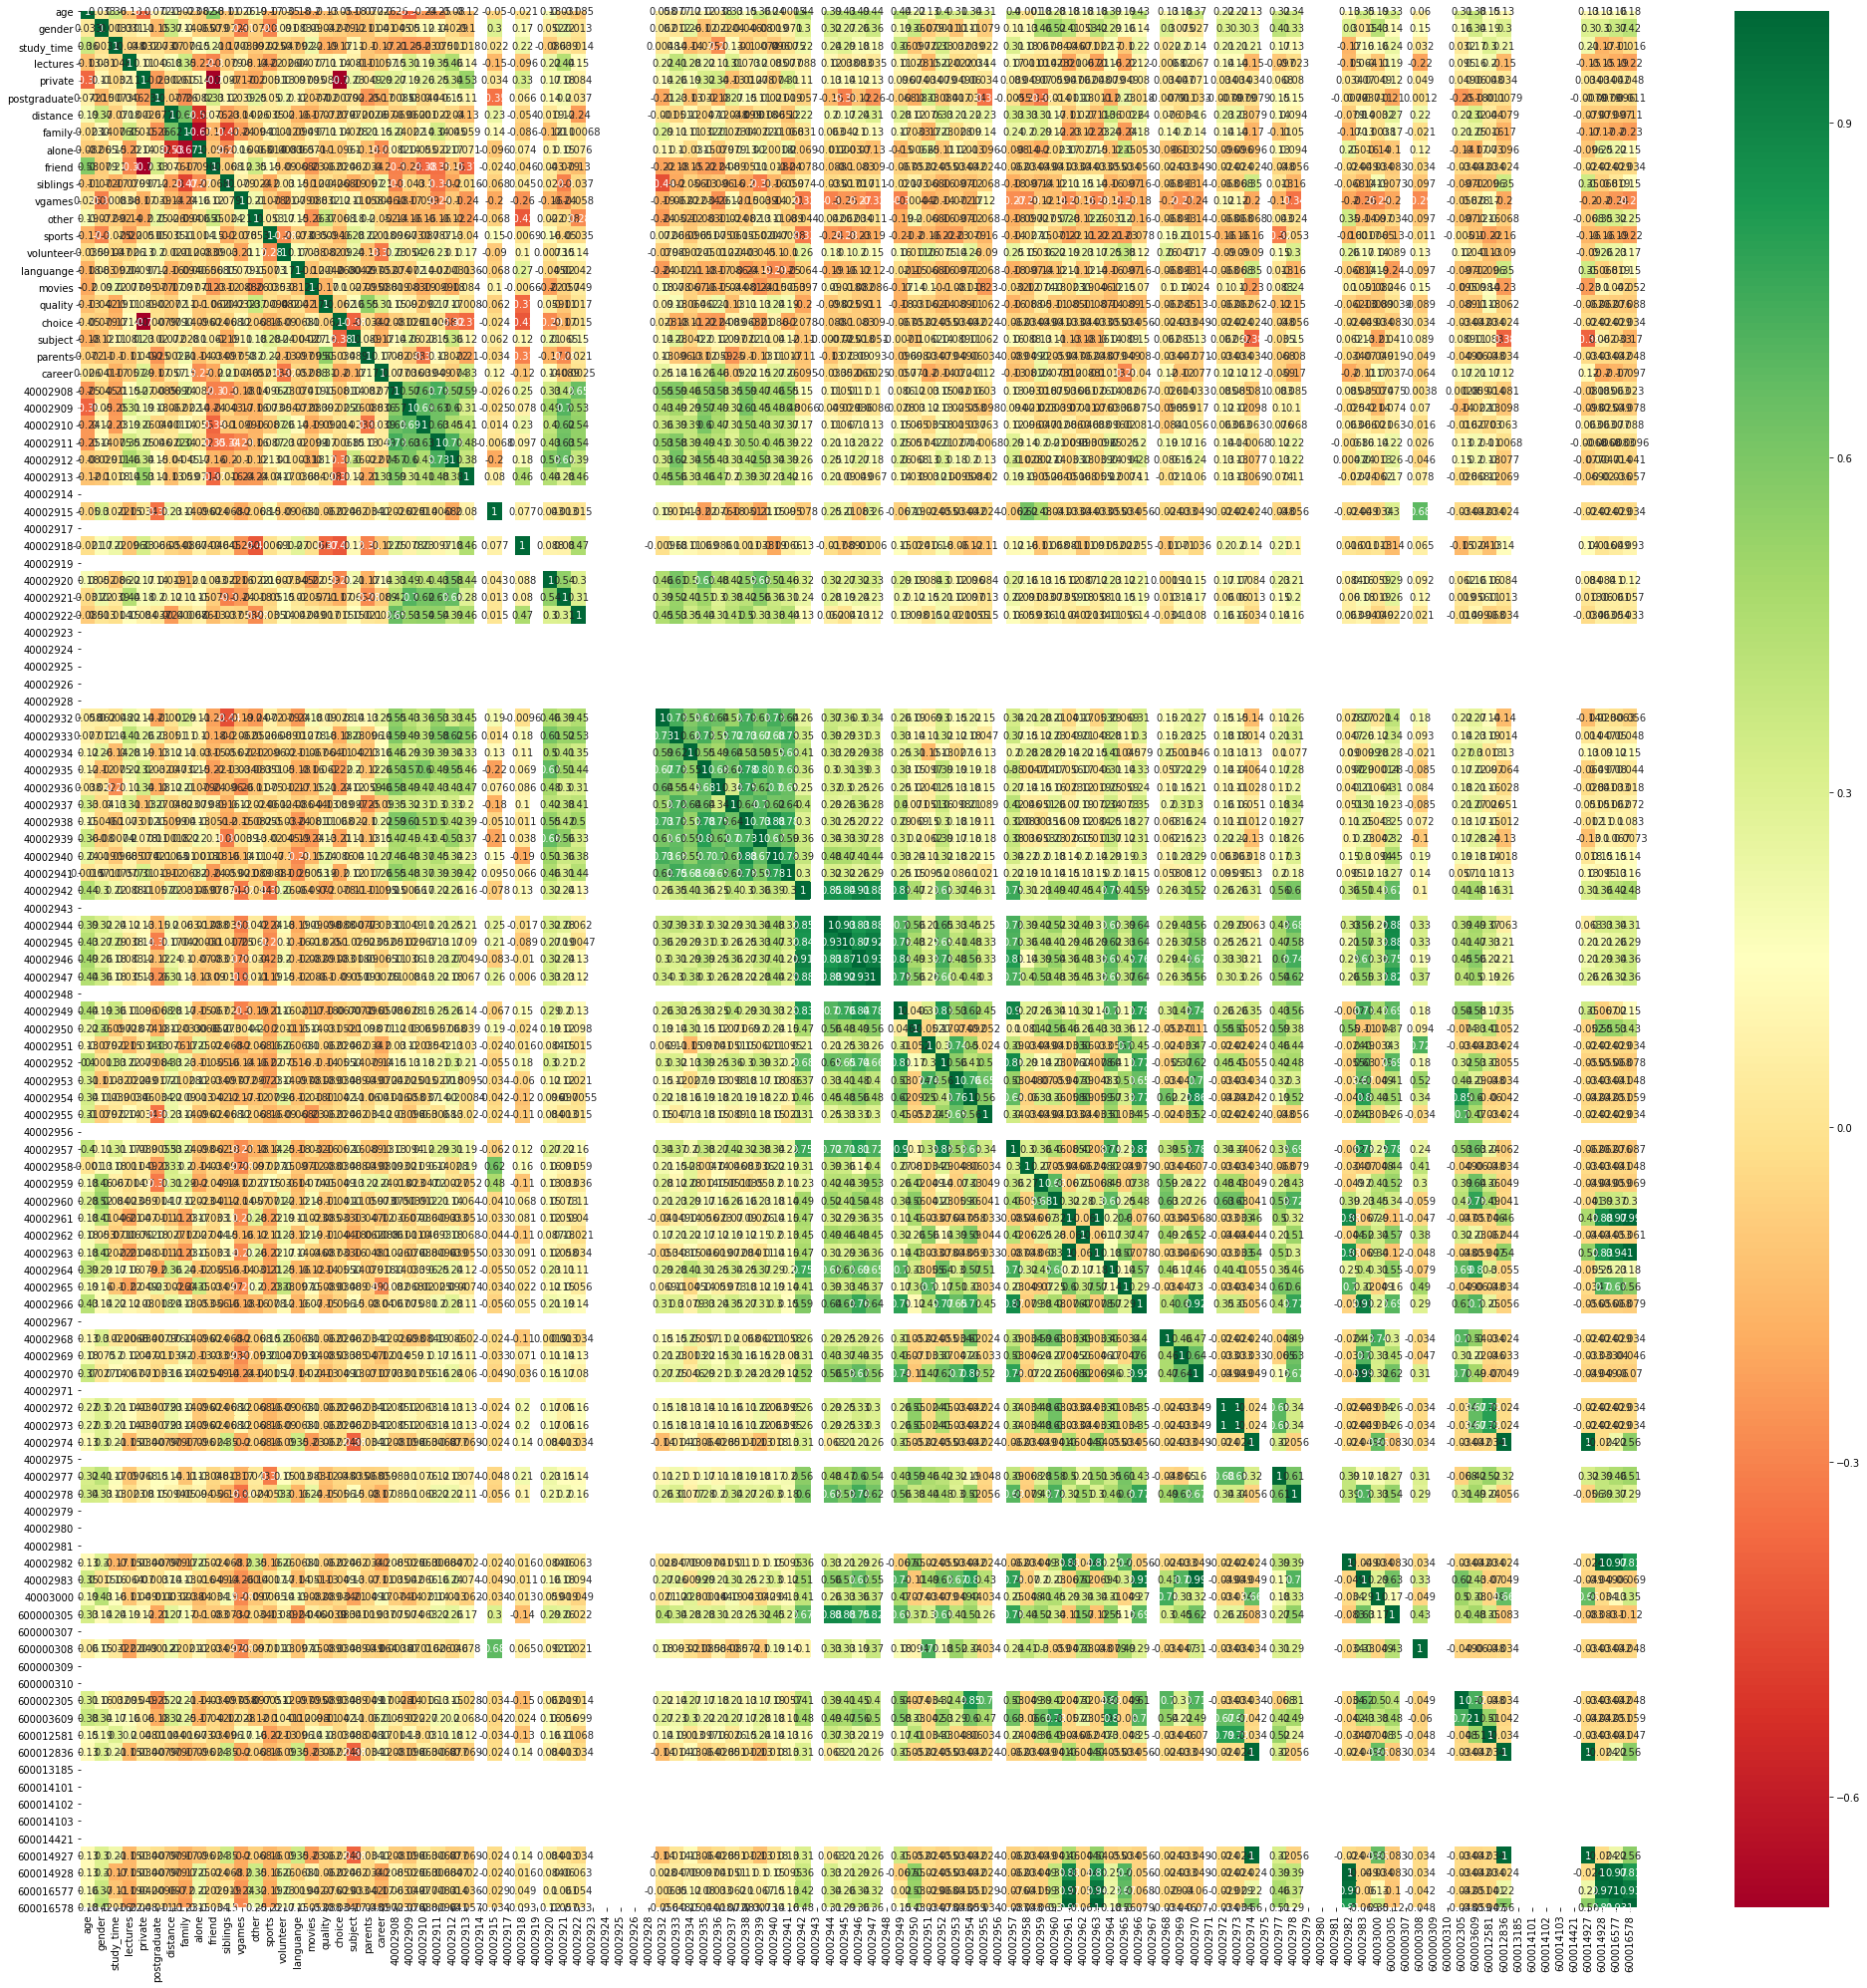

In [129]:

corrmat = data_selected.corr(method="pearson")
top_corr_features = corrmat.index
plt.figure(figsize=(35, 35))
g = sns.heatmap(data_selected[top_corr_features].corr(), annot=True, cmap="RdYlGn")
plt.show()